<a href="https://colab.research.google.com/github/cmadding/MSDS_7333_QTW/blob/master/CaseStudy15/Case_Study_Unit_15_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Case Study Unit 15  

Allen Ansari, Chris Ballenger, Shantanu Godbole, Chad Madding

DS 7333 Quantifying the World

August 15, 2020

#### Introduction
In this unit, we will be using an ensemble of categorical prediction methods to find the best accuracy and ROC score. A gridsearch will assist in removing low performing features from random forest and keep the optimal features. We will focus on metrics like the F1-Score, accuracy, recall, precision, and the ROC score to find the best prediction rate while finding the best balance between true positives and false negatives.

#### Methods
In this project, we will first work on data exploration, any needed categorical data conversion, and replacing missing values.
After exploration and cleaning, we will look at the best categorical predictors while removing lesser features. We will perform a gridsearch to assist with hyperparameter tuning for our random forest parameters. Finally, we will design an ensemble model with the highest ROC score, accuracy, precision, recall, and F1-Score.

In [ ]:
#Connect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# visualize missing values
import missingno as msno

# model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# linear classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# non-linear classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# ensemble learners
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# model persistence
from pickle import dump
from pickle import load

# ignore deprecated warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# read in the dataset
data = pd.read_csv('/content/drive/My Drive/Colab/Data/final_project.csv')
data.shape

(160000, 51)

The dataset contains 51 variables and 160,000 rows of data.

We can look at the first few rows of data to see the makeup of the dataset.

In [ ]:
#the first five rows of data
print("Table 1: First Five Rows Of Data")
data.head()

Table 1: First Five Rows Of Data


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,6.187465,13.251523,25.665413,-5.017267,10.503714,-2.517678,2.117910,5.865923,-6.666158,1.791497,-1.909114,-1.737940,-2.516715,3.553013,euorpe,-0.801340,1.142950,1.005131,-18.473784,July,tuesday,-3.851669,0.0%,-1.940031,-5.492063,0.627121,-0.873824,$1313.96,-1.353729,-5.186148,-10.612200,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,-11.708859,-2.352809,-25.014934,9.799608,-10.960705,1.504000,-2.397836,-9.301839,-1.999413,5.045258,-5.809984,10.814319,-0.478112,10.590601,asia,0.818792,-0.642987,0.751086,3.749377,Aug,wednesday,1.391594,-0.02%,2.211462,-4.460591,1.035461,0.228270,$1962.78,32.816804,-5.150012,2.147427,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,1.572647,-4.170771,12.078602,-5.158498,7.302780,-2.192431,-4.065428,-7.675055,4.041629,-6.633628,1.700321,-2.419221,2.467521,-5.270615,asia,-0.718315,-0.566757,4.171088,11.522448,July,wednesday,-3.262082,-0.01%,0.419607,-3.804056,-0.763357,-1.612561,$430.47,-0.333199,8.728585,-0.863137,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,-2.000255,-19.286668,10.995330,-5.914378,2.511400,1.292362,-2.496882,-15.722954,-2.735382,1.117536,1.923670,-14.179167,1.470625,-11.484431,asia,-0.052430,-0.558582,9.215569,30.595226,July,wednesday,-2.285241,0.01%,-3.442715,4.420160,1.164532,3.033455,$-2366.29,14.188669,-6.385060,12.084421,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,6.667530,1.965913,-28.106348,-1.258950,5.759941,0.472584,-1.150097,-14.118709,4.527964,-1.284372,-9.026317,-7.039818,-1.978748,-15.998166,asia,-0.223449,0.350781,1.811182,-4.094084,July,tuesday,0.921047,0.01%,-0.431640,12.165494,-0.167726,-0.341604,$-620.66,-12.578926,1.133798,30.004727,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


In [ ]:
print("Table 2: Basic Statistical Details")
data.describe()

Table 2: Basic Statistical Details


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x27,x28,x31,x33,x34,x35,x36,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,159957.000000,159970.000000,159964.000000,159969.000000,159966.000000,159965.000000,159974.000000,159973.000000,159960.000000,159965.000000,159962.000000,159971.000000,159973.000000,159953.000000,159978.000000,159964.000000,159970.000000,159965.000000,159961.000000,159959.000000,159959.000000,159970.000000,159973.000000,159969.000000,159977.000000,159964.000000,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,0.002253,0.030232,-1.334402,0.007669,0.008104,0.001215,0.006223,0.012040,0.012694,0.024555,0.299074,-0.029137,0.008400,0.722028,-0.000806,-0.001066,-0.004159,0.031543,-0.005945,-0.006567,-0.000426,0.000936,0.006453,6.059130,0.004253,-2.316526,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,7.871429,8.769633,14.750990,8.953837,6.964097,3.271779,4.984065,7.569351,4.540714,7.595316,5.806203,9.409635,5.412010,14.909127,1.263656,0.843258,6.774047,14.439534,2.767508,1.747762,8.014180,2.379558,1.593183,16.891603,5.134322,17.043549,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,-36.306571,-38.092869,-64.197967,-38.723514,-30.905214,-17.002359,-26.042983,-34.395898,-20.198686,-35.633396,-26.677396,-43.501854,-23.644193,-66.640341,-6.364653,-3.857484,-32.003555,-72.896705,-12.289364,-7.451454,-36.116606,-10.008149,-6.866024,-74.297559,-22.101647,-74.059196,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,-5.288196,-5.903274,-11.379492,-6.029945,-4.696755,-2.207774,-3.344027,-5.071470,-3.056131,-5.101553,-3.607789,-6.361115,-3.649766,-9.268532,-0.852784,-0.567293,-4.597919,-9.702464,-1.874206,-1.183681,-5.401084,-1.610337,-1.068337,-5.249882,-3.458716,-13.953629,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,-0.018176,0.010941,-1.624439,-0.003473,0.002467,0.003535,0.012754,0.024541,0.015904,0.044703,0.433055,-0.026385,0.011144,1.029609,-0.003723,-0.001501,0.037138,0.244210,0.002013,-0.006079,-0.013089,-0.002399,0.003645,6.184410,0.019068,-2.701867,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.305734,5.331573,5.935032,8.374524,6.041959,4.701299,2.211660,3.366853,5.101962,3.073002,5.164732,4.306566,6.316457,3.672678,11.028035,0.851765,0.567406,4.649773,9.936995,1.856369,1.179460,5.411667,1.603089,1.079895,17.420148,3.463308,8.981616,19.266367,1.453507,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072,1.000000
max,1.600849,27.988178,63.545653,38.906025,26.247812,35.550110,92.390605,149.150634,39.049831,27.377842,37.945583,36.360443,73.279354,42.392177,32.546340,13.782559,21.961123,37.057048,19.652986,33.515550,27.814560,46.237503,24.863012,58.490500,5.314169,3.951652,28.645074,67.753845,12.279356,7.787120,34.841428,9.892426,6.999544,90.467981,21.545591,88.824477,100.050432,22.668041,6.680922,19.069759,1.669205,150.859415,20.836854,8.226552,66.877604,1.000000


In [ ]:
print("Table 3: Categorical Details")
data.describe(include=['object'])

Table 3: Categorical Details


,x24,x29,x30,x32,x37
count,159972,159970,159970,159969,159977
unique,3,12,5,12,129198
top,asia,July,wednesday,0.01%,$-336.77
freq,138965,45569,101535,40767,6


There are a few categorical varables that will need encoding. x 32 and x37 look to not be encoded correctley. x32 has a % sigh and x37 has a dollar amount. We can remove the $ sign and the % sigh then conver them to a float value.

In [ ]:
# x32 has a % that needs to be removed and convert to float
def PerSign(var):
    var = var.str.replace('%', "")
    return var.astype("float")

data['x32'] = PerSign(data['x32'])
data.x32.head()

0    0.00
1   -0.02
2   -0.01
3    0.01
4    0.01
Name: x32, dtype: float64

In [ ]:
# x37 has a $ that needs to be removed and convert to float
def DollarSign(var):
    var = var.str.replace('$', "")
    return var.astype("float")

data['x37'] = DollarSign(data['x37'])
data.x37.head()

0    1313.96
1    1962.78
2     430.47
3   -2366.29
4    -620.66
Name: x37, dtype: float64

In [ ]:
# divide the variables based on their types
objects = data.loc[:, data.dtypes == object]
numerics = data.loc[:, data.dtypes == float]
responseVariable = data.y

There are only three catagorital variables. With entries like asia, July and wednesday, these look to be variables we can encode with one hot encoding.

In [ ]:
# count the 'opjects'
print("Table 4: Categorical Counts")
objects.describe().T

Table 4: Categorical Counts


,count,unique,top,freq
x24,159972,3,asia,138965
x29,159970,12,July,45569
x30,159970,5,wednesday,101535


#### Addressing data distribuation

We will look at the distrubation of the data to see if any type of transformation will be needed.

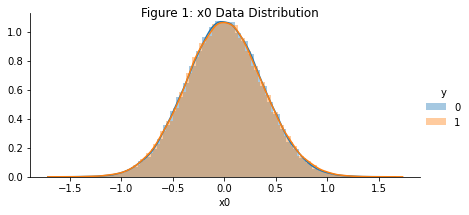

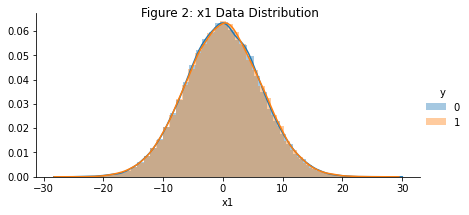

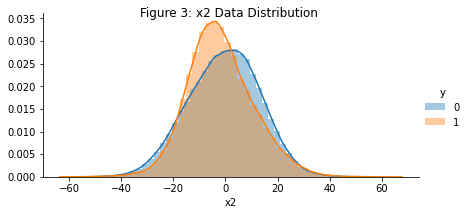

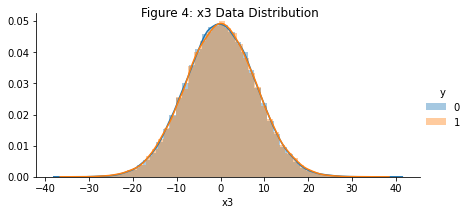

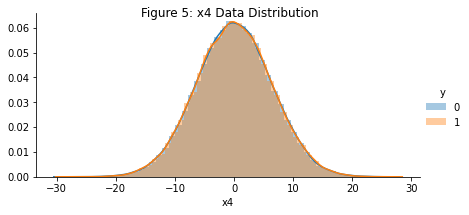

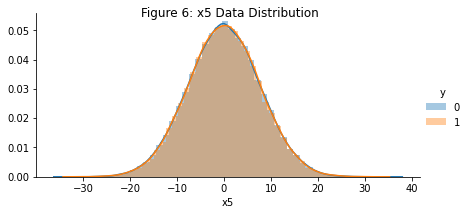

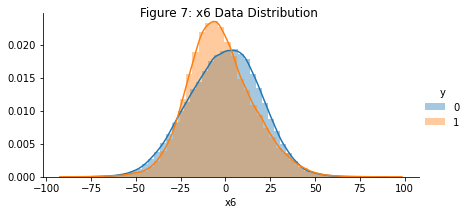

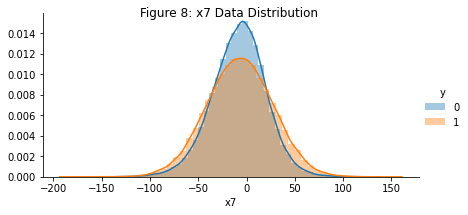

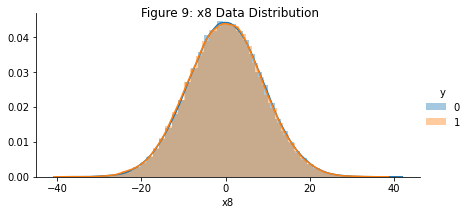

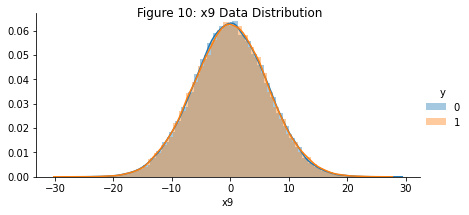

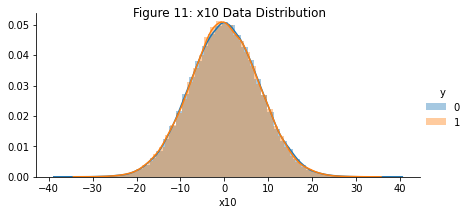

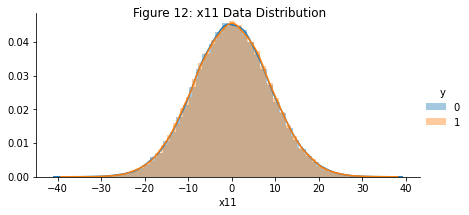

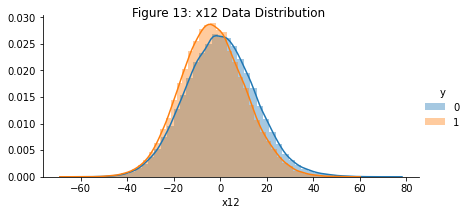

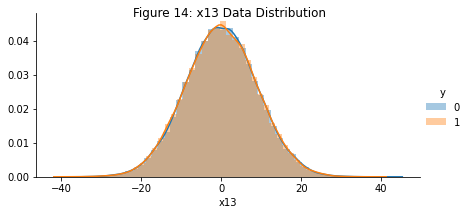

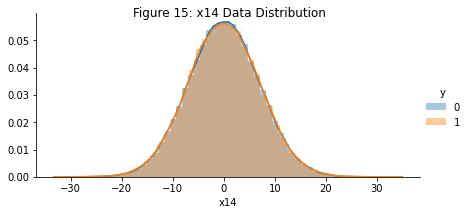

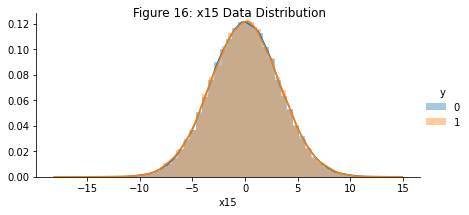

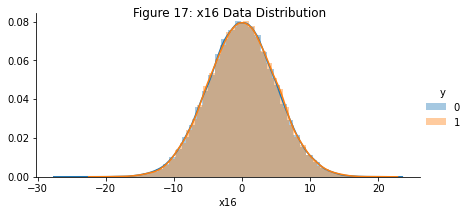

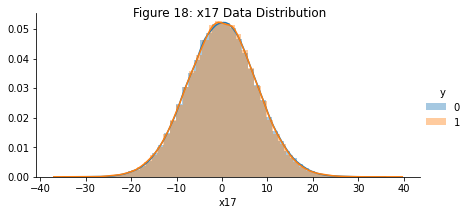

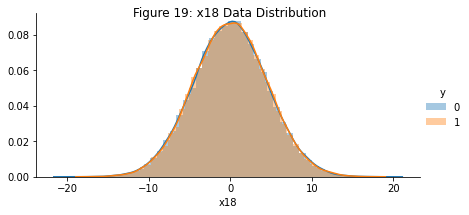

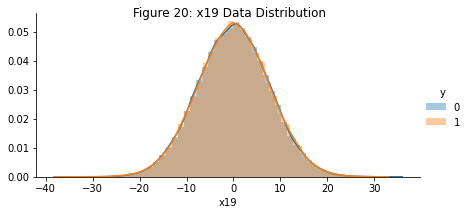

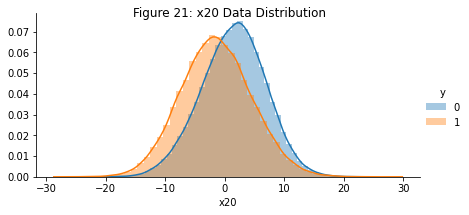

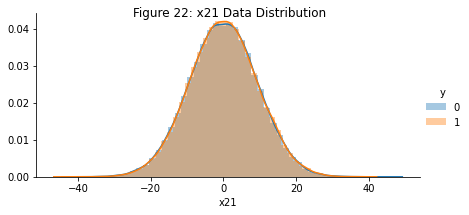

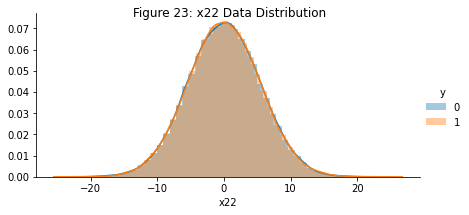

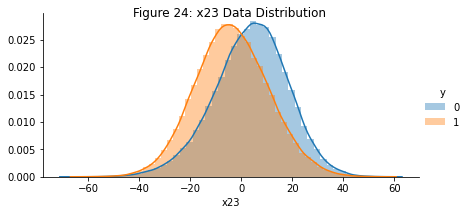

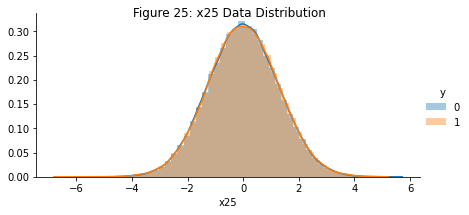

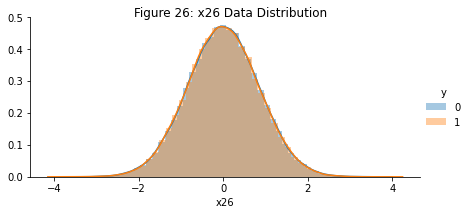

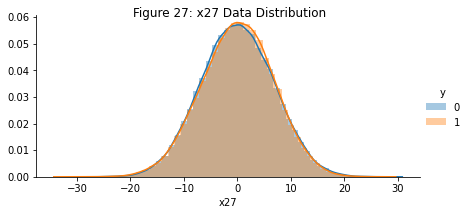

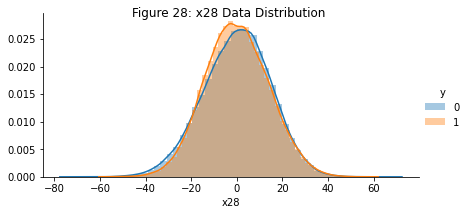

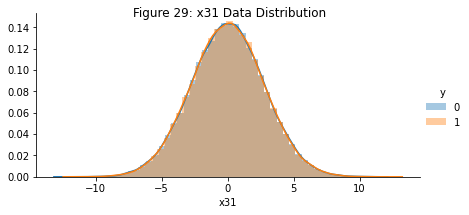

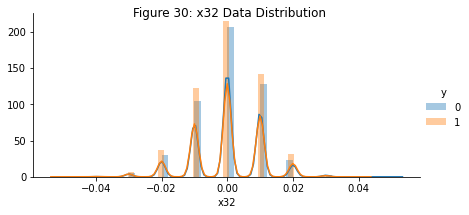

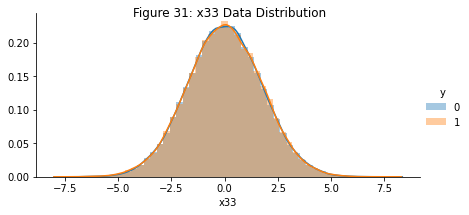

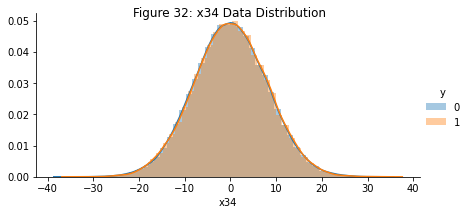

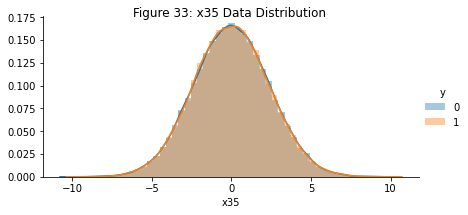

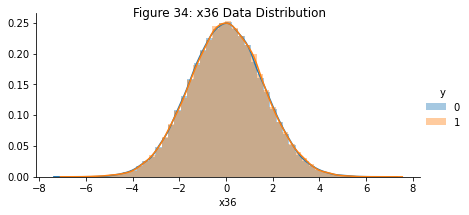

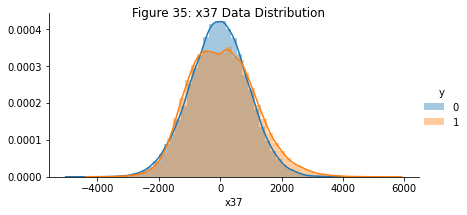

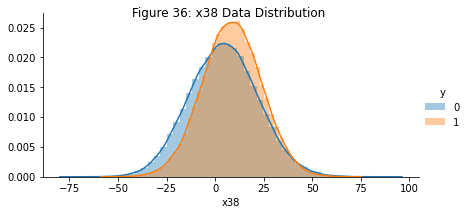

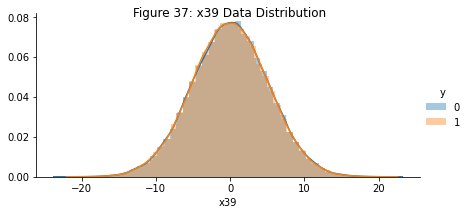

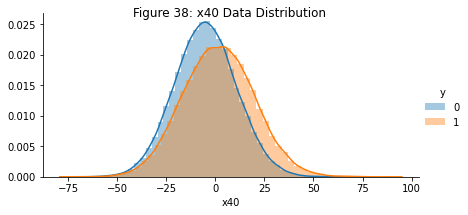

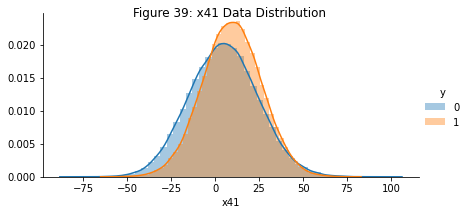

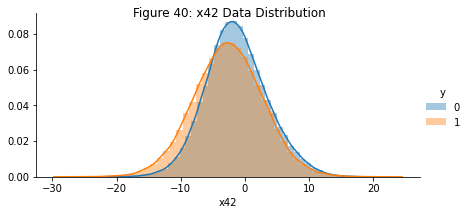

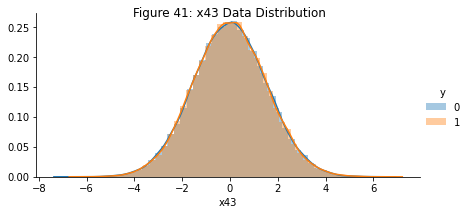

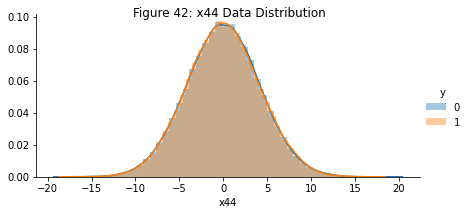

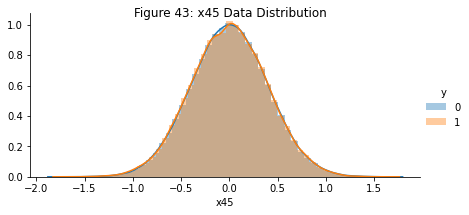

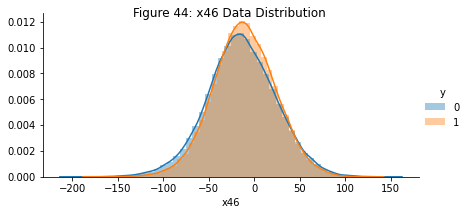

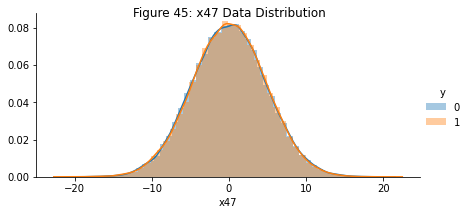

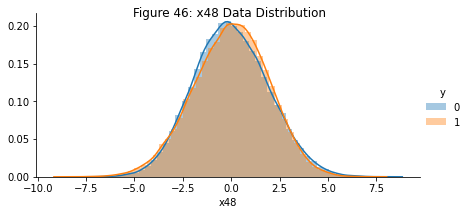

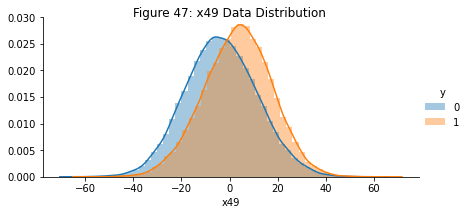

In [ ]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(data.drop(['y'], axis=1).select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(data, hue='y',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Data Distribution"]))))
    plt.show()

Figures 1 through 47 above look at the data distribution for each numeric variable. All show a reasonably normal distribution, and no transformation will be needed.

Figures 48, 49, and 50 show the distribution of the categorical data. While there are some differences in the data, we feel no transformation will be needed.

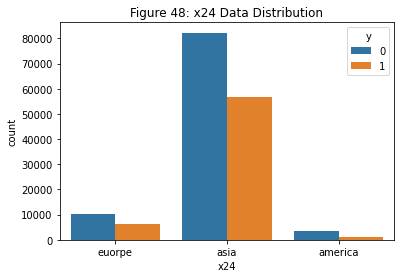

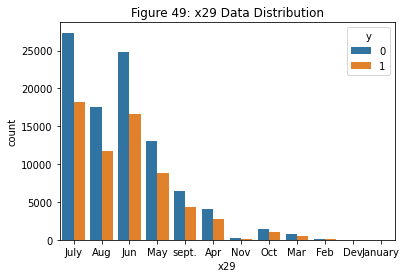

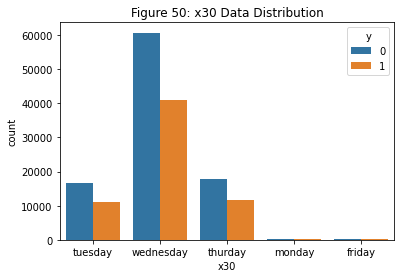

In [ ]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(data.select_dtypes(include='O').columns.values)
for i in colnames[0:]:
    ax = plt.axes()
    sns.countplot(x=i, data=data, hue="y", ax = ax)
    ax.set_title(''.join(map(str, list(["Figure ",colnames.index(i)+48,": ",i," Data Distribution"]))))
    plt.show()

#### Addressing missing data

We have chosen to replace missing numerical data with the median of that variable and missing categorical data with the mode of the variable.

In [ ]:
#code used from https://shravan-kuchkula.github.io/ml/Binary-Classification/#replacing-numeric-missing-values-with-median
def replaceNumMissingData(df):
    temp_df = df.copy()
    columnnames = df.columns

    print("##############################")
    print("## NA count Before Cleaning ##")
    print("##############################")
    print(df.isnull().sum())

    #replacing missing continous values with median
    for i in range(0,len(columnnames)):
        try:
            temp_array =df[df[columnnames[i]]!=np.nan][columnnames[i]]
            # replace NAs with median for continous variables created from above arrays
            temp_df[columnnames[i]] =temp_df[columnnames[i]].replace(np.nan,temp_array.median())     
        except Exception as e:
            print(e.args)

    print("##############################")
    print("## NA Count After Cleaning  ##")
    print("##############################")
    print(temp_df.isnull().sum())
    df = temp_df
    return df

In [ ]:
dataWithoutMissing = replaceNumMissingData(numerics)
dataWithoutMissing.info()

##############################
## NA count Before Cleaning ##
##############################
x0     26
x1     25
x2     38
x3     37
x4     26
x5     37
x6     26
x7     27
x8     21
x9     30
x10    43
x11    30
x12    36
x13    31
x14    34
x15    35
x16    26
x17    27
x18    40
x19    35
x20    38
x21    29
x22    27
x23    47
x25    22
x26    36
x27    30
x28    35
x31    39
x32    31
x33    41
x34    41
x35    30
x36    27
x37    23
x38    31
x39    23
x40    36
x41    40
x42    26
x43    37
x44    40
x45    29
x46    31
x47    37
x48    32
x49    32
dtype: int64
##############################
## NA Count After Cleaning  ##
##############################
x0     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x25    0
x26    0
x27    0
x28    0
x31    0
x32    0
x33    0
x34    0
x35    0
x36    0
x37    0
x38    0
x39    

In [ ]:
#code from https://shravan-kuchkula.github.io/ml/Binary-Classification/#replace-categorical-missing-values-with-mode
def replaceCatMissingData(df):
    temp_df = df.copy()
    columnnames = df.columns

    print("##############################")
    print("## NA count Before Cleaning ##")
    print("##############################")
    print(df.isnull().sum())

    for i in range(0,len(columnnames)):
        try:
            temp_array = df[df[columnnames[i]]!=np.nan][columnnames[i]]
            temp_df[columnnames[i]] =temp_df[columnnames[i]].replace(np.nan,str(temp_array.mode()[0]))      
        except Exception as e:
            print(e.args)

    print("##############################")
    print("## NA Count After Cleaning  ##")
    print("##############################")
    print(temp_df.isnull().sum())
    df = temp_df
    return df

In [ ]:
dataWithoutMissingCat = replaceCatMissingData(objects)
dataWithoutMissingCat.info()

##############################
## NA count Before Cleaning ##
##############################
x24    28
x29    30
x30    30
dtype: int64
##############################
## NA Count After Cleaning  ##
##############################
x24    0
x29    0
x30    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   x24     160000 non-null  object
 1   x29     160000 non-null  object
 2   x30     160000 non-null  object
dtypes: object(3)
memory usage: 3.7+ MB


#### Correlation Information

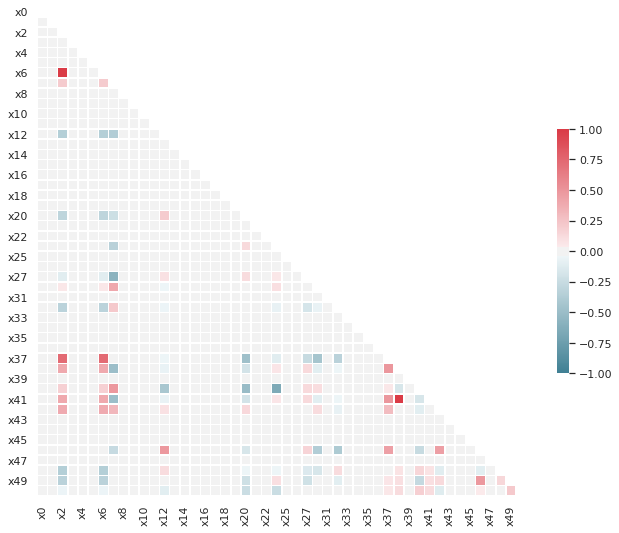

In [ ]:
#Code from https://shravan-kuchkula.github.io/ml/Binary-Classification/#remove-highly-correlated-variables
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There are two sets of variables with high correlation. We will be removing them to assist in generating the best models.

In [ ]:
import numpy as np
def reduce_features(df, verbose = False):
    # calculate the correlation matrix
    corr_matrix  = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    #Get all of the correlation values > 95%
    x = np.where(upper > 0.95)

    #Display all field combinations with > 95% correlation
    cf = pd.DataFrame()
    cf['drop'] = upper.columns[x[1]]
    cf['keep'] = upper.index[x[0]]

    #Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
    corr = [0] * len(cf)
    for i in range(0, len(cf)):
        corr[i] =  upper[cf['drop'][i]][cf['keep'][i]] 

    cf['Correlation'] = corr

    if( verbose ):
        print('There are ', str(len(cf['drop'])), ' field correlations > 95%.')
        display(cf)
        
        print('Dropping the following ', str(len(to_drop)), ' highly correlated fields.')
        to_drop
        
    #Check columns before drop 
    if( verbose ):
        print('\r\n*********Before: Dropping Highly Correlated Fields*************************************')
        display(df.info(verbose=False))

    # Drop the highly correlated features from our training data 
    df = df.drop(to_drop, axis=1)

    #Check columns after drop 
    if( verbose ):
        print('\r\n*********After: Dropping Highly Correlated Fields**************************************')
        df.info(verbose=False)
    
    return df

In [ ]:
data_reduced = reduce_features(data, True)

There are  2  field correlations > 95%.


,drop,keep,Correlation
0,x6,x2,1.0
1,x41,x38,1.0


Dropping the following  2  highly correlated fields.

*********Before: Dropping Highly Correlated Fields*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 51 entries, x0 to y
dtypes: float64(47), int64(1), object(3)
memory usage: 62.3+ MB


None


*********After: Dropping Highly Correlated Fields**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 49 entries, x0 to y
dtypes: float64(45), int64(1), object(3)
memory usage: 59.8+ MB
